# Demo 2: Multilayer Perceptron 
This demo we will demo code for using Multilayer Perceptron model to solve the classification problem:
-   Problem: Surface Defect classification (with the NEU surface defect dataset)
-   Dataset: NEU surface defect dataset <http://faculty.neu.edu.cn/songkechen/zh_CN/zhym/263269/list/index.htm>(NEU SDD)
-   Library packages:
    -   Numpy (Numpy arrays are very fast and can perform large computations in a very short time)
    -   PIL (Simple image processing package: read, show, resize,...)
    -   Matplotlib (Plot package: visualize result,....)
    -   TensorFlow (This is an open-source library that is used for DL/ML/AI)
    -   Scikit-Learn (Machine Learning models: KNN,SVM,Decision Tree, Metrics,...)
Tasks Outlines:
## 0. Task 0: Preparing dataset
-   Downloads dataset, unpacking dataset,...
-   Transform it to input (features) and ouput (labels) where the model in tensorflow library can read, and training on,...
-   Normalize or standardlize dataset (we may do it after some evaluations on the raw data)
-   Devide dataset to trainset and testset (maybe one more validation_set)
## 1. Task 1: Constructing model by using TensorFlow library:
-   Create a multilayer perceptron model
-   Training model on our trainset and applying the early stopping during the training
## 2. Task 2: Evaluating the performance of trained model on the testset
-   Predict the label (which class) for each input image in the testset
-   Compute the metrics (quantitative measurements) 
    -   For example on Classification task: Accuracy, Precesion, Recall, Confusion Matrix, F1-Score, Cross-Entropy Loss,...
*****************************************************************************

# Import all packages

In [56]:
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn import metrics

## 0. Task 0: Preparing Dataset

Go to the notebook file: Demo_Read_NEU_dataset.ipynb to get detail of demo code for this step

### 0.1. Define a function get all paths to each image in the dataset and the class label of each image

In [57]:
def get_all_img_label_path(input_dir:str,
                            img_suffix = '.bmp')->(list,list):
    """
    parameters:
    -   input_dir: the directory to the data folder
    -   img_suffix: siffix type of image in the data folder to read
    output: a tuple of two lists:
    -   List of all path to each image in the data folder
    -   List of relative class for each image in the data folder
    """
    label_to_number = {"Cr":0,"In":1,"Pa":2,"PS":3,"RS":4,"Sc":5}
    list_img_paths = []
    list_labels = []
    for root,dirs,files in os.walk(input_dir):
        for file in files:
            file_name,file_suffix = os.path.splitext(file)
            if file_suffix == img_suffix:
                list_img_paths.append(os.path.join(root,file))
                list_labels.append(label_to_number[file_name[:2]])
    return (list_img_paths,list_labels)


### 0.2. Define a function to get all image array and its class label (which are in type np.array)
In this function we also resize the all image to the same new size = (width, height)

In [58]:
# Resize the image to small dimensional of width and height
def get_data(list_img_paths:list,
             list_labels:list,
             is_resize:bool= True,
             width:int = 8,
             height:int = 8) -> (np.array,np.array):
    """
    Parameters:
    -   list_img_paths: List of all paths to image in the data folder
    -   list_labels: The list of labels relative to each image in the list_img_paths
    -   is_resize: Default is True means resize all image in the dataset
        to the new size (width,height)
    -   width: The width size which we want to resize to
    -   height: The height size which we want to resize to

    Output: A tuple of two arrays
    -   data_array with shape (N,h,w), where
        -   N is the number of image
        -   h is the height
        -   w is the width
    -   label_array with shape (N,)
    """
    data = []
    for i in range(len(list_img_paths)):
        path_img = list_img_paths[i]
        img = Image.open(path_img)
        if is_resize:
            img = img.resize(size = (width,height),
                            resample=Image.BICUBIC)
        data.append(np.array(img))
    return (np.array(data),np.array(list_labels))

### 0.3. Getting data by using two previouse function

In [59]:
# Get the list of all path to images, and the list of relative labels
dir_NEUCLS = "/Users/user/Victor2023/Dataset/NEU-CLS"
list_img_paths,list_labels = get_all_img_label_path(input_dir=dir_NEUCLS,
                                                    img_suffix='.bmp')

width = 32
height = 32
X,label = get_data(list_img_paths=list_img_paths,
               list_labels=list_labels,
               is_resize=True,
               width=width,
               height= height)


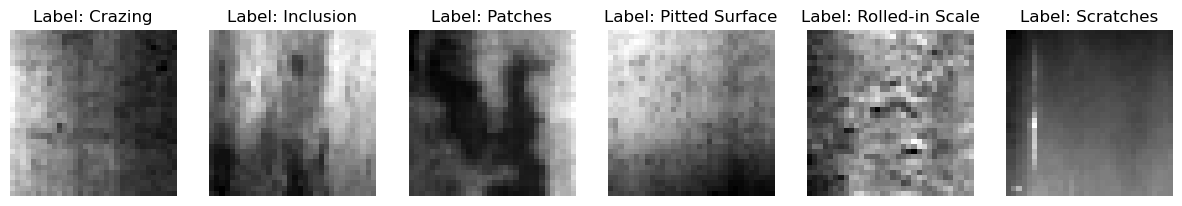

In [60]:
# Plotting some images to take an overview of our dataset
index_to_label = ["Crazing","Inclusion","Patches","Pitted Surface","Rolled-in Scale","Scratches"]
# Visualize one sample of each class
_, indices = np.unique(label,return_index=True) # get one index of each class
# Plot
_, axes = plt.subplots(nrows = 1,
                       ncols = len(indices),
                       figsize = (15,6))
for i in range(len(indices)):
    index = indices[i]
    axes[i].set_axis_off()
    axes[i].imshow(X[index], cmap = plt.cm.gray, interpolation= "nearest")
    axes[i].set_title(f"Label: {index_to_label[label[index]]}")

### Note!
The shape of data input of perceptron model should be (N_samples,N_features). In which:
-   N_samples: The total number of samples we have (number of images)
-   N_features: the number of features in each sample

Back to our data:
-   Data is image in grayscale we resize to same size (width,height), here is 32 x 32 pixels. Each pixels is one feature of sample, so totally we have 32*32 number of features for each sample.
-   We have to reshape our data from (N_samples,height,width) to (N_samples,height * width)


In [61]:
print("The currently shape of input dataset X is:", X.shape)

The currently shape of input dataset X is: (1800, 32, 32)


In [62]:
n_samples = X.shape[0]
X = X.reshape((n_samples,-1))
# Scaling feature from range [0,255] to range [0,1]
# Each pixel is a feature of input image, which has normally value in range [0,255] 
X = X/255


# Convert integers to dummy variables (i.e. one hot encoded)
# Formating the truth label in form of output of model
# y now is the truth output which model must learn to predict
y = to_categorical(label)


In [63]:
print("The currently shape of input dataset X is:", X.shape)
print("The currently shape of dummy y is:", y.shape)


The currently shape of input dataset X is: (1800, 1024)
The currently shape of dummy y is: (1800, 6)


### 0.4. Deviding our dataset to trainset, validset and testset

In [64]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,shuffle=False)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,shuffle=False)

In [65]:
print("Number of samples in the train subset:", len(y_train))
print("Number of samples in the train subset:", len(y_val))
print("Number of samples in the test subset:", len(y_test))

Number of samples in the train subset: 1296
Number of samples in the train subset: 324
Number of samples in the test subset: 180


## 1. Task 1: Constructing model by using TensorFlow library:

### 1.1. Creating multilayer perceptron model
The perceptron operation:

$$output = activation(dot(input,kernel)+ bias)$$

In [66]:
# Creating a multilayer perceptron model:
dim_output = 6
input_shape = (X.shape[1],)
model = keras.Sequential()
model.add(keras.layers.Dense(64,
                             input_shape = input_shape,
                             activation = 'relu'))
# model.add(keras.layers.Dropout(0.))
model.add(keras.layers.Dense(32,
                             activation = 'relu'))
# model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(16,
                             activation = 'relu'))
model.add(keras.layers.Dense(dim_output,
                             activation = 'softmax'))


In [67]:
# Show the model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                65600     
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 6)                 102       
                                                                 
Total params: 68,310
Trainable params: 68,310
Non-trainable params: 0
_________________________________________________________________


Model summary: 

Layer perceptron 1: 
-   input shape: 1024
-   output shape: 64 => bias shape: 64
-   weight shape: (1024,64)
-   The total parameters is: $1024*64+64 = 65600$

Layer perceptron 2: 
-   input shape: 64
-   output shape: 32 => bias shape: 32
-   weight shape: (64,32)
-   The total parameters is: $64*32+32 = 2080$

Layer perceptron 3: 
-   input shape: 32
-   output shape: 16 => bias shape: 16
-   weight shape: (32,16)
-   The total parameters is: $32*16+16 = 528$

Layer perceptron 4 (final output layer): 
-   input shape: 16
-   output shape: 6 => bias shape: 6
-   weight shape: (16,6)
-   The total parameters is: $16*6 + 6 = 102$

### 1.2. Training model with EarlyStopping, ModelCheckpoint, and ReduceLROnPlateau

In [68]:
# Define EarlyStopping, ModelCheckpoint, ReduceLearningRateOnPlateau.
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   verbose=1,
                   patience=30)
mc = ModelCheckpoint('best_model.h5',
                     monitor='val_accuracy',
                     mode='max',
                     verbose=1,
                     save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=30,
                              min_lr=0.0001,
                              mode = 'min')

In [69]:
epochs = 500
optimizer = keras.optimizers.Adam()
loss = keras.losses.categorical_crossentropy
q_metrics = ['accuracy']
model.compile(optimizer=optimizer,
                   loss = loss,
                   metrics=q_metrics)
history = model.fit(X_train,y_train,
                         batch_size=32,
                         epochs = epochs,
                         validation_data=(X_val,y_val),
                         verbose=2,
                         callbacks=[es,mc,reduce_lr])

Epoch 1/500



Epoch 1: val_accuracy improved from -inf to 0.25617, saving model to best_model.h5
41/41 - 1s - loss: 1.7752 - accuracy: 0.1914 - val_loss: 1.7475 - val_accuracy: 0.2562 - lr: 0.0010 - 1s/epoch - 33ms/step
Epoch 2/500

Epoch 2: val_accuracy did not improve from 0.25617
41/41 - 0s - loss: 1.7074 - accuracy: 0.2508 - val_loss: 1.6810 - val_accuracy: 0.2531 - lr: 0.0010 - 110ms/epoch - 3ms/step
Epoch 3/500

Epoch 3: val_accuracy improved from 0.25617 to 0.26235, saving model to best_model.h5
41/41 - 0s - loss: 1.6624 - accuracy: 0.2585 - val_loss: 1.6451 - val_accuracy: 0.2623 - lr: 0.0010 - 135ms/epoch - 3ms/step
Epoch 4/500

Epoch 4: val_accuracy improved from 0.26235 to 0.27160, saving model to best_model.h5
41/41 - 0s - loss: 1.6081 - accuracy: 0.2809 - val_loss: 1.6187 - val_accuracy: 0.2716 - lr: 0.0010 - 213ms/epoch - 5ms/step
Epoch 5/500

Epoch 5: val_accuracy did not improve from 0.27160
41/41 - 0s - loss: 1.5685 - accuracy: 0.3117 - val_loss: 1.6301 - val_accuracy: 0.2469 - lr:

In [70]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


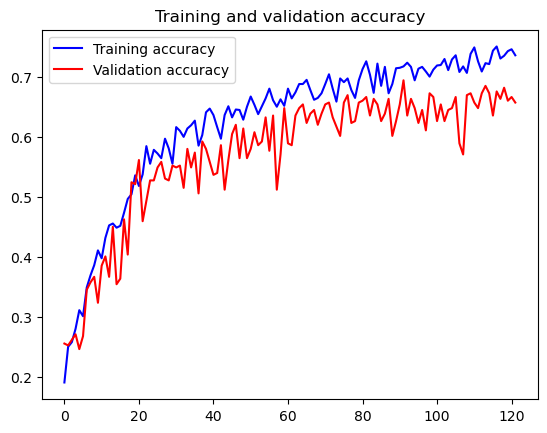

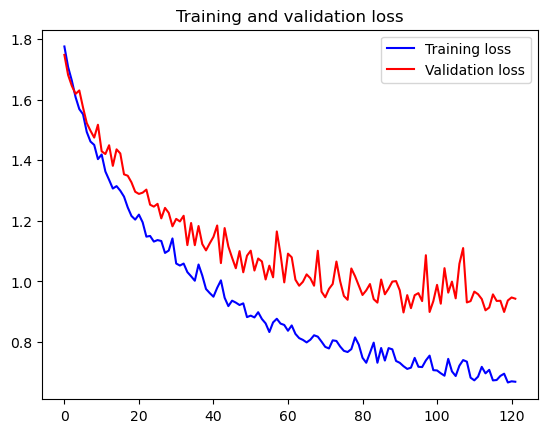

In [71]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))

plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

## 2. Task 2: Evaluating the performance of trained model on the testset

### 2.1. Predict the label (which class) for each input image in the testset

In [73]:
output_test = model.predict(X_test)

6/6 [==============================] - 0s 2ms/step


In [74]:
pred_test = np.argmax(output_test,axis=-1)
truth_test = np.argmax(y_test,axis=-1)

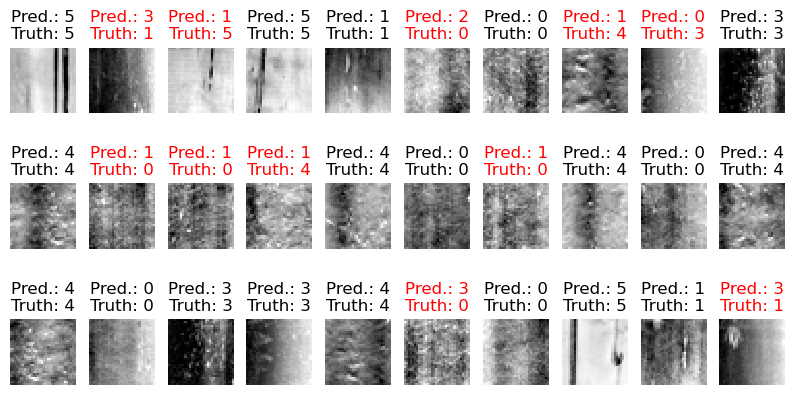

In [75]:
# Visualize the first 30 test samples and show their predicted digit value in the title.
_,axes = plt.subplots(nrows = 3,ncols = 10, figsize= (10,5))
for r in range(3):
    for c in range(10):
        index = r*10 + c
        axes[r,c].set_axis_off()
        image = X_test[index].reshape((width,height))
        pred_label = pred_test[index]
        true_label = truth_test[index]
        axes[r,c].imshow(image, cmap = plt.cm.gray_r, interpolation = "nearest")
        if pred_label == true_label:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}")
        else:
            axes[r,c].set_title(f"Pred.: {pred_label}\nTruth: {true_label}",color = 'red')

### 2.2. Compute the metrics (quantitative measurements)

Text(0.5, 0.98, 'Number occurrences of each class on test set')

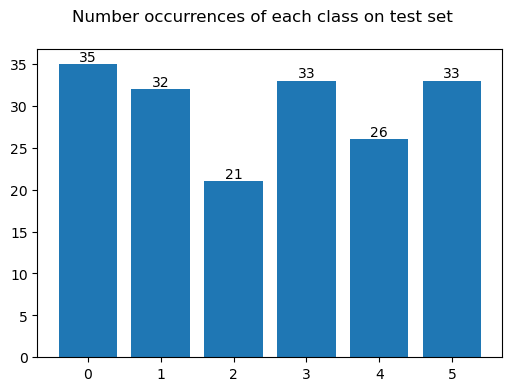

In [76]:
nb_classes = len(np.unique(truth_test))
## Visual bar plot of number occurrences of each class in testset:
statistic_class = np.unique(truth_test,return_counts=True)
categoricalClasses = [f'{C}' for C in statistic_class[0]]
fig,ax = plt.subplots(1,1,figsize=(6,4))
ax.bar(x = categoricalClasses, height = statistic_class[1],width = 0.8)
for i in range(nb_classes):
    ax.text(categoricalClasses[i],statistic_class[1][i],
            str(statistic_class[1][i]),ha='center',va = 'bottom')
fig.suptitle("Number occurrences of each class on test set")

In [77]:
# Classification report:
print(f"Classification report for classifier {model}:\n"
      f"{metrics.classification_report(truth_test,pred_test,digits=4)}\n")

Classification report for classifier <keras.engine.sequential.Sequential object at 0x13d2b72e0>:
              precision    recall  f1-score   support

           0     0.5926    0.4571    0.5161        35
           1     0.5238    0.6875    0.5946        32
           2     0.8333    0.9524    0.8889        21
           3     0.6875    0.6667    0.6769        33
           4     0.6250    0.7692    0.6897        26
           5     0.8696    0.6061    0.7143        33

    accuracy                         0.6667       180
   macro avg     0.6886    0.6898    0.6801       180
weighted avg     0.6813    0.6667    0.6644       180




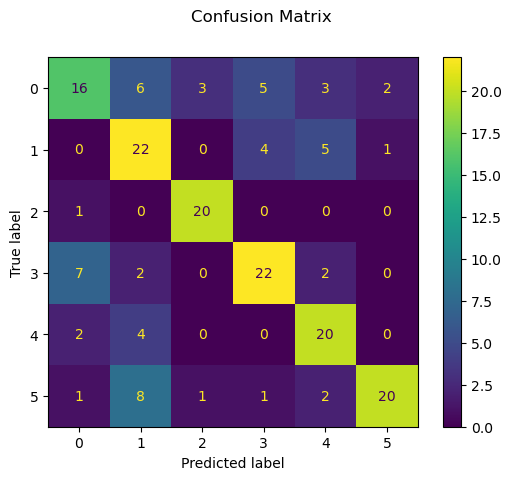

In [78]:
# Confusion matrix
disp = metrics.ConfusionMatrixDisplay.from_predictions(truth_test,pred_test)
disp.figure_.suptitle("Confusion Matrix")
# print(f"Confusion matrix:\n{disp.confusion_matrix}")
plt.show()